# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025AA05328

Name: VasuDevan S

Email: 2025aa05328@wilp.bits-pilani.ac.in

Date: 24-Jan-2026

In [1]:
# 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os

In [2]:
# 2: Deep learning frameworks and image processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os

from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# 3: Dataset Loading
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moazeldsokyx/dogs-vs-cats")+"/dataset"
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dogs-vs-cats' dataset.
Path to dataset files: /kaggle/input/dogs-vs-cats/dataset


In [4]:
# 4: Dataset Metadata
dataset_name = "Dogs vs Cats"
dataset_source = "Kaggle - moazeldsokyx/dogs-vs-cats"
n_samples = 20000
n_classes = 2
sample_each_class = int(n_samples/n_classes)
samples_per_class = f"min: {sample_each_class}, max: {sample_each_class}, avg: {sample_each_class}"
image_shape = [64, 64, 1]
problem_type = "classification"
batch_size=32

In [5]:
# 5: Primary Metric Selection
primary_metric = "accuracy"
metric_justification = """
Accuracy is chosen as the primary metric because the Dogs vs Cats dataset
is balanced with equal samples per class, making accuracy a reliable indicator of model performance.
"""

In [6]:
# 6: Print Dataset Information
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Dogs vs Cats
Source: Kaggle - moazeldsokyx/dogs-vs-cats
Total Samples: 20000
Number of Classes: 2
Samples per Class: min: 10000, max: 10000, avg: 10000
Image Shape: [64, 64, 1]
Primary Metric: accuracy
Metric Justification: 
Accuracy is chosen as the primary metric because the Dogs vs Cats dataset 
is balanced with equal samples per class, making accuracy a reliable indicator of model performance.



In [7]:
# 6.1: Explore Dataset Structure
print("\nDATASET STRUCTURE")
train_dir = os.path.join(path, 'train')
for class_name in ['cats', 'dogs']:
    class_dir = os.path.join(train_dir, class_name)
    if os.path.exists(class_dir):
        count = len([f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name.capitalize()}: {count} images available")


DATASET STRUCTURE
Cats: 10000 images available
Dogs: 10000 images available



SAMPLE RAW IMAGES (Before Preprocessing)


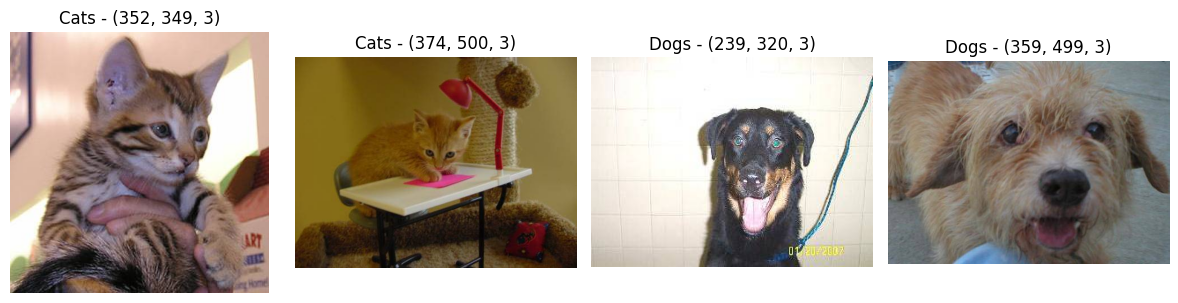

In [8]:
# 6.2: Sample Raw Images
print("\nSAMPLE RAW IMAGES (Before Preprocessing)")
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, class_name in enumerate(['cats', 'dogs']):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.exists(class_dir):
        files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))][:2]
        for j, img_file in enumerate(files):
            img = cv2.imread(os.path.join(class_dir, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i*2+j].imshow(img)
            axes[i*2+j].set_title(f"{class_name.capitalize()} - {img.shape}")
            axes[i*2+j].axis('off')
plt.tight_layout()
plt.show()

In [9]:
# 7: Load and Preprocess Data
X_data = []
y_data = []

train_dir = os.path.join(path, 'train')
IMG_SIZE = 64

def load_images(folder_path, label, max_images=sample_each_class):
    images = []
    labels = []

    files = [f for f in os.listdir(folder_path)
             if f.endswith(('.jpg', '.jpeg', '.png'))][:max_images]

    for img_file in files:
        try:
            img_path = os.path.join(folder_path, img_file)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0

            images.append(img)
            labels.append(label)
        except:
            pass

    return images, labels

cat_dir = os.path.join(train_dir, 'cats')
if os.path.exists(cat_dir):
    imgs, lbls = load_images(cat_dir, label=0)
    X_data.extend(imgs)
    y_data.extend(lbls)

dog_dir = os.path.join(train_dir, 'dogs')
if os.path.exists(dog_dir):
    imgs, lbls = load_images(dog_dir, label=1)
    X_data.extend(imgs)
    y_data.extend(lbls)

X_data = np.array(X_data)
y_data = np.array(y_data)

X_data = X_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(f"Loaded {len(X_data)} images")
print("Image shape:", X_data.shape)

Loaded 20000 images
Image shape: (20000, 64, 64, 1)


In [10]:
# 8: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.10, random_state=42, stratify=y_data
)

# Convert to categorical
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

# Update metadata
n_samples = len(X_data)
train_samples = len(X_train)
test_samples = len(X_test)
train_test_ratio = "90/10"

In [11]:
# 9: Print Split Information
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")

# 9.1: Class Distribution
print("\nCLASS DISTRIBUTION")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls} ({'Cat' if cls==0 else 'Dog'}): {count} samples")

# 9.2: Data Statistics
print("\nDATA STATISTICS")
print(f"Min pixel value: {X_train.min():.3f}")
print(f"Max pixel value: {X_train.max():.3f}")
print(f"Mean pixel value: {X_train.mean():.3f}")
print(f"Std pixel value: {X_train.std():.3f}")


Train/Test Split: 90/10
Training Samples: 18000
Test Samples: 2000

CLASS DISTRIBUTION
Class 0 (Cat): 9000 samples
Class 1 (Dog): 9000 samples

DATA STATISTICS
Min pixel value: 0.000
Max pixel value: 1.000
Mean pixel value: 0.460
Std pixel value: 0.252


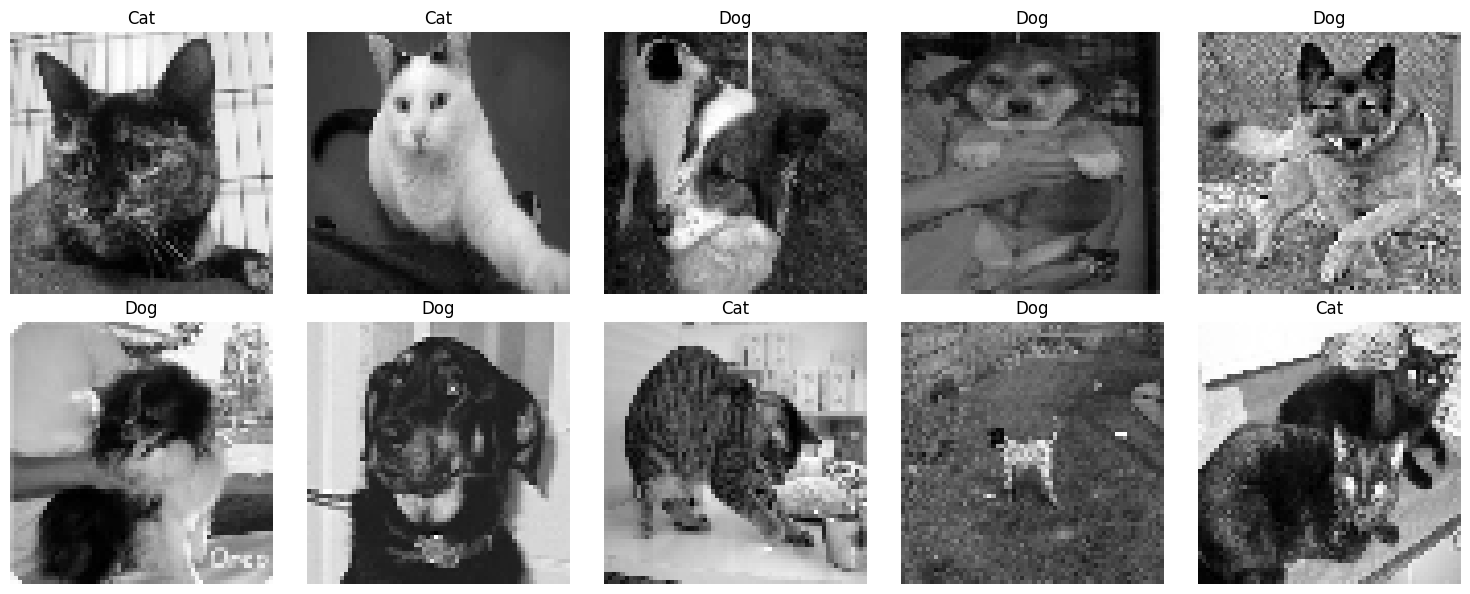

In [12]:
# 10: Visualize Sample Images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X_train[i].reshape(64, 64), cmap='gray')
    ax.set_title(f"{'Cat' if y_train[i]==0 else 'Dog'}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# 11: Build Custom CNN
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture with Global Average Pooling
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

In [14]:
# 12: Create and Compile Custom CNN
custom_cnn = build_custom_cnn(tuple(image_shape), n_classes)
custom_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
custom_cnn_params = custom_cnn.count_params()
custom_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,930 (363.01 KB)

 Trainable params: 92,930 (363.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 13: Train Custom CNN
print("\nCUSTOM CNN TRAINING")
custom_cnn_start_time = time.time()
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history_cnn = custom_cnn.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)
custom_cnn_training_time = time.time() - custom_cnn_start_time



CUSTOM CNN TRAINING
Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5470 - loss: 0.6846 - val_accuracy: 0.5433 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6063 - loss: 0.6607 - val_accuracy: 0.6222 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6425 - loss: 0.6339 - val_accuracy: 0.6822 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6849 - loss: 0.5940 - val_accuracy: 0.6161 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7093 - loss: 0.5645 - val_accuracy: 0.7039 - val_loss: 0.5709 - learning_rate: 0.0010
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7527 - loss: 0.5194 - val_accuracy: 0.7572 - val_loss: 0.5015 - learning_rate: 0.0010
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.

In [16]:
# 14: Track Custom CNN Loss
custom_cnn_initial_loss = float(history_cnn.history['loss'][0])
custom_cnn_final_loss = float(history_cnn.history['loss'][-1])

In [17]:
# 15: Print Custom CNN Training Results
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 87.19 seconds
Initial Loss: 0.6761
Final Loss: 0.3143


In [18]:
# 16: Evaluate Custom CNN
print("\nCUSTOM CNN EVALUATION")

y_pred_probs = custom_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

custom_cnn_accuracy = accuracy_score(y_test, y_pred)
custom_cnn_precision = precision_score(y_test, y_pred, average='macro')
custom_cnn_recall = recall_score(y_test, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_test, y_pred, average='macro')


CUSTOM CNN EVALUATION
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [19]:
# 17: Print Custom CNN Performance
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")


Custom CNN Performance:
Accuracy:  0.8405
Precision: 0.8409
Recall:    0.8405
F1-Score:  0.8405


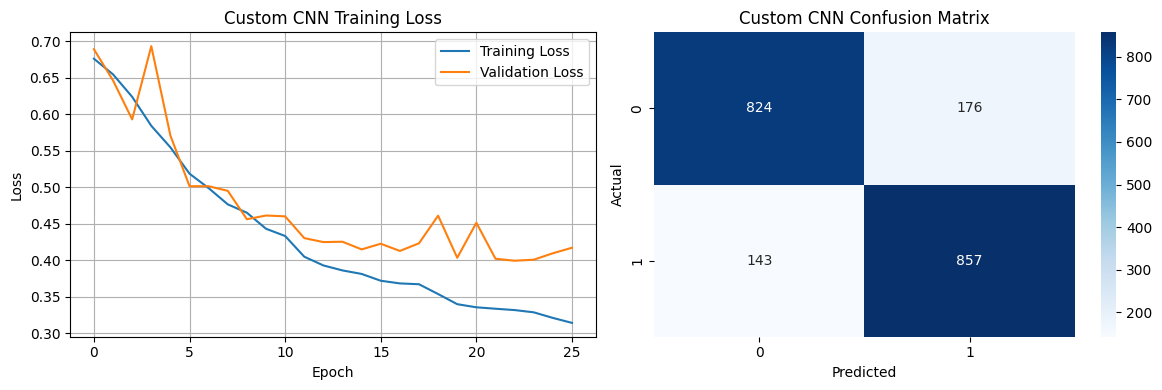

In [20]:
# 18: Visualize Custom CNN Results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_cnn.history['loss'], label='Training Loss')
axes[0].plot(history_cnn.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Custom CNN Training Loss')
axes[0].legend()
axes[0].grid(True)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Custom CNN Confusion Matrix')

plt.tight_layout()
plt.show()

In [21]:
# 19: Transfer Learning Implementation
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")

pretrained_model_name = "ResNet50"


TRANSFER LEARNING IMPLEMENTATION


In [22]:
# 20: Build Transfer Learning Model
def build_transfer_learning_model(base_model_name, input_shape, n_classes, unfreeze_top=15, use_dropout=False):
    """
    Build transfer learning model with optional fine-tuning (unfreeze top layers)
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-unfreeze_top:]:
        layer.trainable = True

    model_layers = [base_model, layers.GlobalAveragePooling2D()]
    if use_dropout:
        model_layers.append(layers.Dropout(0.3))
    model_layers.append(layers.Dense(n_classes, activation='softmax'))

    model = models.Sequential(model_layers)

    return model

In [23]:
# 21: Prepare RGB Data for Transfer Learning
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

print(f"RGB Training data shape: {X_train_rgb.shape}")
print(f"RGB Test data shape: {X_test_rgb.shape}")

RGB Training data shape: (18000, 64, 64, 3)
RGB Test data shape: (2000, 64, 64, 3)


In [24]:
# 22: Create and Compile Transfer Learning Model
transfer_model = build_transfer_learning_model(
    base_model_name='ResNet50',
    input_shape=(64, 64, 3),
    n_classes=n_classes,
    unfreeze_top=15,
    use_dropout=True
)

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

base_model = transfer_model.layers[0]
frozen_layers = sum(not layer.trainable for layer in base_model.layers)
trainable_layers = sum(layer.trainable for layer in base_model.layers) + 2
total_parameters = transfer_model.count_params()
trainable_parameters = sum([np.prod(w.shape) for w in transfer_model.trainable_weights])


print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

Base Model: ResNet50
Frozen Layers: 160
Trainable Layers: 17
Total Parameters: 23,591,810
Trainable Parameters: 5,524,482
Using Global Average Pooling: YES


In [25]:
# 23: Train Transfer Learning Model
print("\nTraining Transfer Learning Model...")

tl_learning_rate = 0.0001
tl_epochs = 30
tl_batch_size = batch_size
tl_optimizer = "Adam"

tl_start_time = time.time()

history_tl = transfer_model.fit(
    X_train_rgb, y_train_cat,
    epochs=tl_epochs,
    batch_size=tl_batch_size,
    validation_split=0.1,
    verbose=1
)

tl_training_time = time.time() - tl_start_time


Training Transfer Learning Model...
Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - accuracy: 0.5901 - loss: 0.7376 - val_accuracy: 0.6517 - val_loss: 0.6270
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6637 - loss: 0.6151 - val_accuracy: 0.6989 - val_loss: 0.5792
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6963 - loss: 0.5751 - val_accuracy: 0.5472 - val_loss: 0.8036
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7040 - loss: 0.5711 - val_accuracy: 0.6928 - val_loss: 0.5777
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7150 - loss: 0.5571 - val_accuracy: 0.6606 - val_loss: 0.6402
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7203 - loss: 0.5447 - val_accuracy: 0.7167 - val_loss: 0.5562
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7326 - loss: 0.5372 - val_accuracy: 0.6617 - val_loss: 0.6335
Epoch 8/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accu

In [26]:
# 24: Track Transfer Learning Loss
tl_initial_loss = float(history_tl.history['loss'][0])
tl_final_loss = float(history_tl.history['loss'][-1])

print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

Training completed in 315.77 seconds
Initial Loss: 0.6906
Final Loss: 0.2312


In [27]:
# 25: Evaluate Transfer Learning Model
# Make predictions
y_pred_tl_probs = transfer_model.predict(X_test_rgb)
y_pred_tl = np.argmax(y_pred_tl_probs, axis=1)

# Calculate metrics
tl_accuracy = accuracy_score(y_test, y_pred_tl)
tl_precision = precision_score(y_test, y_pred_tl, average='macro')
tl_recall = recall_score(y_test, y_pred_tl, average='macro')
tl_f1 = f1_score(y_test, y_pred_tl, average='macro')

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step


In [28]:
# 26: Print Transfer Learning Performance
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")


Transfer Learning Performance:
Accuracy:  0.6995
Precision: 0.7016
Recall:    0.6995
F1-Score:  0.6987


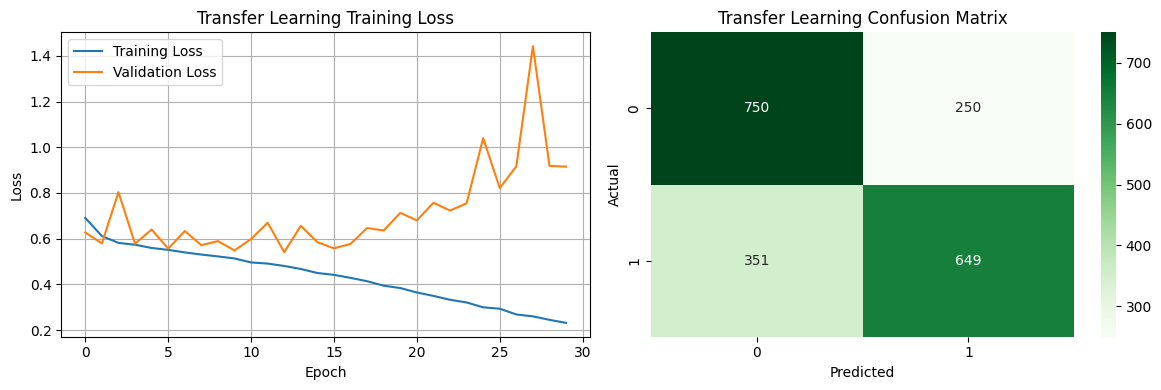

In [29]:
# 27: Visualize Transfer Learning Results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training curves
axes[0].plot(history_tl.history['loss'], label='Training Loss')
axes[0].plot(history_tl.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Transfer Learning Training Loss')
axes[0].legend()
axes[0].grid(True)

# Confusion matrix
cm_tl = confusion_matrix(y_test, y_pred_tl)
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Transfer Learning Confusion Matrix')

plt.tight_layout()
plt.show()

In [30]:
# 28: Model Comparison
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        custom_cnn.count_params()
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

print("\nMODEL COMPARISON")
print(comparison_df.to_string(index=False))


MODEL COMPARISON
           Metric   Custom CNN  Transfer Learning
         Accuracy     0.840500       6.995000e-01
        Precision     0.840871       7.015561e-01
           Recall     0.840500       6.995000e-01
         F1-Score     0.840457       6.987317e-01
Training Time (s)    87.188072       3.157681e+02
       Parameters 92930.000000       5.524482e+06


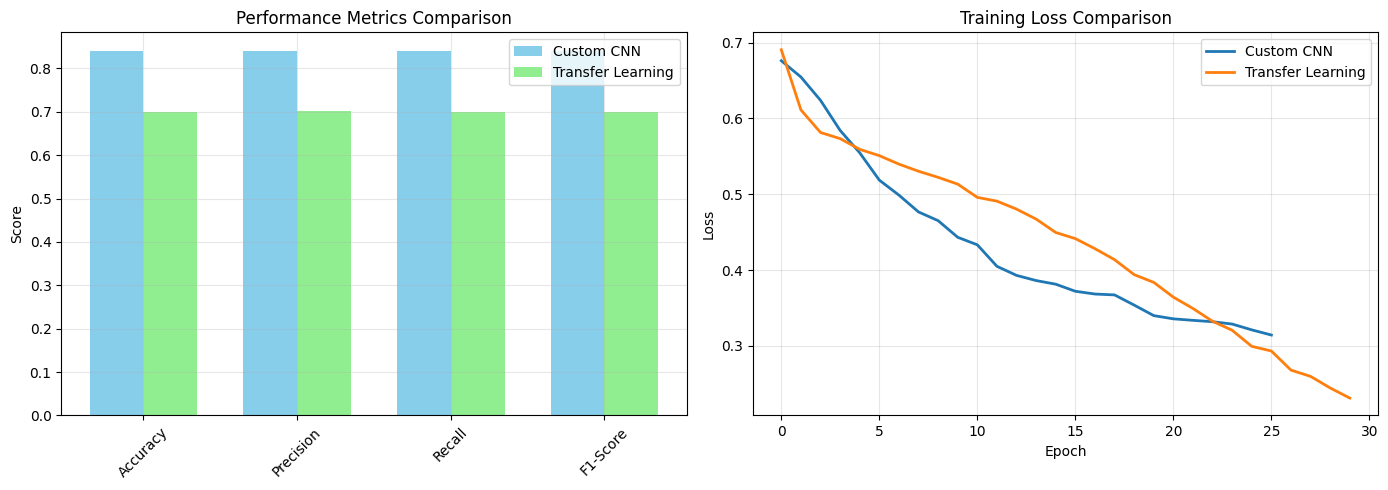

In [31]:
# 29: Visual Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
custom_values = [custom_cnn_accuracy, custom_cnn_precision, custom_cnn_recall, custom_cnn_f1]
tl_values = [tl_accuracy, tl_precision, tl_recall, tl_f1]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, custom_values, width, label='Custom CNN', color='skyblue')
axes[0].bar(x + width/2, tl_values, width, label='Transfer Learning', color='lightgreen')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training curves comparison
axes[1].plot(history_cnn.history['loss'], label='Custom CNN', linewidth=2)
axes[1].plot(history_tl.history['loss'], label='Transfer Learning', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
# 30: Analysis
analysis_text = f"""
The custom CNN outperformed the transfer learning model across all evaluation metrics, achieving higher
accuracy ({custom_cnn_accuracy:.4f} vs {tl_accuracy:.4f}), precision ({custom_cnn_precision:.4f} vs {tl_precision:.4f}),
recall ({custom_cnn_recall:.4f} vs {tl_recall:.4f}), and F1-score ({custom_cnn_f1:.4f} vs {tl_f1:.4f}),
indicating an absolute accuracy improvement of {(custom_cnn_accuracy - tl_accuracy):.4f}.
Training from scratch allowed the custom CNN to learn dataset-specific features, while the transfer learning
model relied on pre-trained ImageNet features that did not fully align with this dataset. Global Average
Pooling in the transfer learning model significantly reduced the number of parameters ({trainable_layers} vs
{custom_cnn_params}), lowering the risk of overfitting but also limiting its representational capacity.
In terms of computational cost, the custom CNN trained faster ({custom_cnn_training_time:.1f}s vs
{tl_training_time:.1f}s) despite having fewer parameters, making it more efficient for this task. Transfer
learning showed slower convergence and required longer training time to stabilize, highlighting that
for this dataset, a well-designed custom CNN is more suitable.
"""

print("\nANALYSIS")
print(analysis_text)



ANALYSIS

The custom CNN outperformed the transfer learning model across all evaluation metrics, achieving higher 
accuracy (0.8405 vs 0.6995), precision (0.8409 vs 0.7016), 
recall (0.8405 vs 0.6995), and F1-score (0.8405 vs 0.6987), 
indicating an absolute accuracy improvement of 0.1410. 
Training from scratch allowed the custom CNN to learn dataset-specific features, while the transfer learning 
model relied on pre-trained ImageNet features that did not fully align with this dataset. Global Average 
Pooling in the transfer learning model significantly reduced the number of parameters (17 vs 
92930), lowering the risk of overfitting but also limiting its representational capacity. 
In terms of computational cost, the custom CNN trained faster (87.2s vs 
315.8s) despite having fewer parameters, making it more efficient for this task. Transfer 
learning showed slower convergence and required longer training time to stabilize, highlighting that 
for this dataset, a well-designed custom

In [33]:
# 31: Assignment Results Summary
def get_assignment_results():
    """
    Generate complete assignment results in required format
    """
    framework_used = "keras"

    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': int(n_samples),
        'n_classes': int(n_classes),
        'samples_per_class': samples_per_class,
        'image_shape': tuple(image_shape),
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': int(train_samples),
        'test_samples': int(test_samples),
        'train_test_ratio': train_test_ratio,

        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': int(len([layer for layer in custom_cnn.layers
                                         if isinstance(layer, layers.Conv2D)])),
                'pooling_layers': int(len([layer for layer in custom_cnn.layers
                                            if isinstance(layer, layers.MaxPooling2D)])),
                'has_global_average_pooling': bool(any(
                    isinstance(layer, layers.GlobalAveragePooling2D)
                    for layer in custom_cnn.layers
                )),
                'output_layer': 'softmax',
                'total_parameters': int(custom_cnn.count_params())
            },
            'training_config': {
                'learning_rate': float(custom_cnn.optimizer.learning_rate.numpy()),
                'n_epochs': int(len(history_cnn.history['loss'])),
                'batch_size': 32,
                'optimizer': custom_cnn.optimizer.__class__.__name__,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': float(custom_cnn_initial_loss),
            'final_loss': float(custom_cnn_final_loss),
            'training_time_seconds': float(custom_cnn_training_time),
            'accuracy': float(custom_cnn_accuracy),
            'precision': float(custom_cnn_precision),
            'recall': float(custom_cnn_recall),
            'f1_score': float(custom_cnn_f1)
        },

        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': int(frozen_layers),
            'trainable_layers': int(trainable_layers),
            'has_global_average_pooling': True,
            'total_parameters': int(total_parameters),
            'trainable_parameters': int(trainable_parameters),
            'training_config': {
                'learning_rate': float(tl_learning_rate),
                'n_epochs': int(tl_epochs),
                'batch_size': int(tl_batch_size),
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': float(tl_initial_loss),
            'final_loss': float(tl_final_loss),
            'training_time_seconds': float(tl_training_time),
            'accuracy': float(tl_accuracy),
            'precision': float(tl_precision),
            'recall': float(tl_recall),
            'f1_score': float(tl_f1)
        },

        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': int(len(analysis_text.split())),

        # Training Success Indicators
        'custom_cnn_loss_decreased': bool(custom_cnn_final_loss < custom_cnn_initial_loss),
        'transfer_learning_loss_decreased': bool(tl_final_loss < tl_initial_loss),
    }

    return results

In [34]:
try:
    assignment_results = get_assignment_results()
    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))

except Exception as e:
    print(f"\n⚠ ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


ASSIGNMENT RESULTS SUMMARY
{
  "dataset_name": "Dogs vs Cats",
  "dataset_source": "Kaggle - moazeldsokyx/dogs-vs-cats",
  "n_samples": 20000,
  "n_classes": 2,
  "samples_per_class": "min: 10000, max: 10000, avg: 10000",
  "image_shape": [
    64,
    64,
    1
  ],
  "problem_type": "classification",
  "primary_metric": "accuracy",
  "metric_justification": "\nAccuracy is chosen as the primary metric because the Dogs vs Cats dataset \nis balanced with equal samples per class, making accuracy a reliable indicator of model performance.\n",
  "train_samples": 18000,
  "test_samples": 2000,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "keras",
    "architecture": {
      "conv_layers": 3,
      "pooling_layers": 3,
      "has_global_average_pooling": true,
      "output_layer": "softmax",
      "total_parameters": 92930
    },
    "training_config": {
      "learning_rate": 0.0001250000059371814,
      "n_epochs": 26,
      "batch_size": 32,
      "optimizer": "Adam

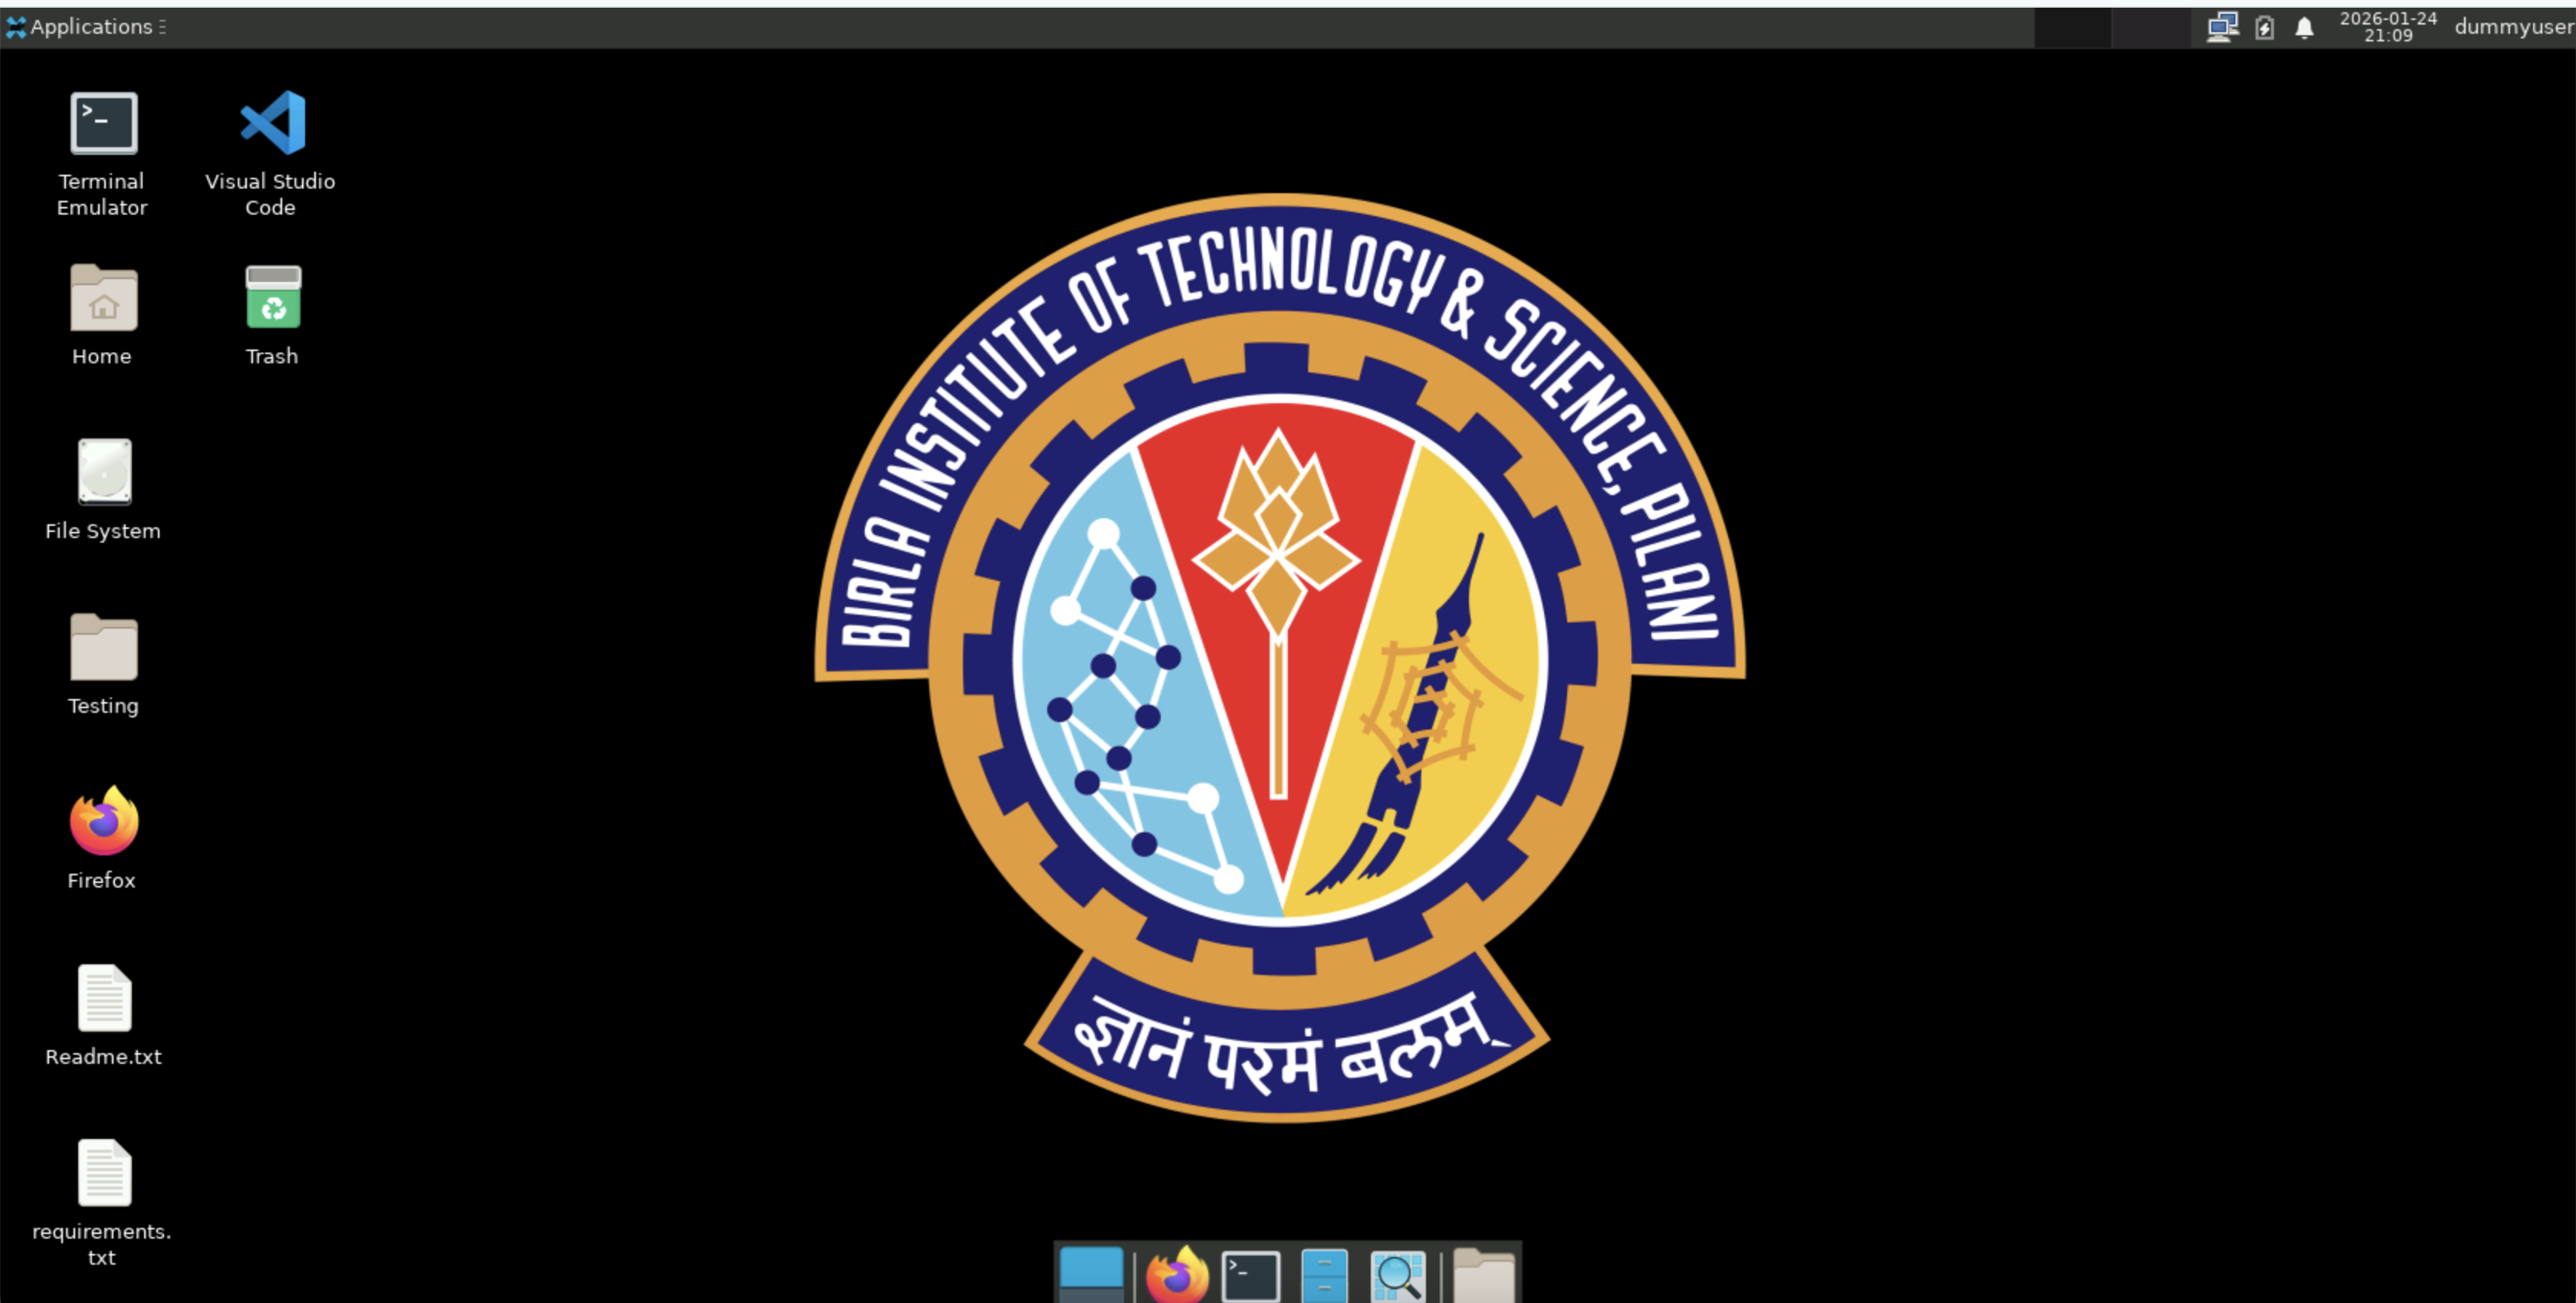